### IMPORTANDO BIBLIOTECAS

In [1]:
import pandas as pd 
import numpy as np
import datetime


import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import plot_roc_curve



from warnings import filterwarnings

filterwarnings("ignore")

### LENDO O DATASET

In [2]:
path = "cancellation_prediction/cancellation_prediction.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
df.head(5)

type  cancellation  days_between_booking_arrival  year_arrival_date  \
0  Fancy Hotel             0                           342               2015   
1  Fancy Hotel             0                           737               2015   
2  Fancy Hotel             0                             7               2015   
3  Fancy Hotel             0                            13               2015   
4  Fancy Hotel             0                            14               2015   

  month_arrival_date  week_number_arrival_date  day_of_month_arrival_date  \
0               July                        27                          1   
1               July                        27                          1   
2               July                        27                          1   
3               July                        27                          1   
4               July                        27                          1   

   num_weekend_nights  num_workweek_nights  num_adults  ...  \
0                   0                    0           2  ...   
1                   0                    0           2  ...   
2                   0                    1           1  ...   
3                   0                    1           1  ...   
4                   0                    2           2  ...   

   num_previous_stays  reserved_room  changes_between_booking_arrival  \
0                   0              C                                3   
1                   0              C                                4   
2                   0              A                                0   
3                   0              A                                0   
4                   0              A                                0   

  deposit_policy  id_travel_agency_booking  id_person_booking  customer_type  \
0     No Deposit                       NaN                NaN              0   
1     No Deposit                       NaN                NaN              0   
2     No Deposit                       NaN                NaN              0   
3     No Deposit                     304.0                NaN              0   
4     No Deposit                     240.0                NaN              0   

   avg_price  required_car_parking_spaces total_of_special_requests  
0        0.0                            0                         0  
1        0.0                            0                         0  
2       75.0                            0                         0  
3       75.0                            0                         0  
4       98.0                            0                         1  

[5 rows x 28 columns]

In [5]:
df.columns

Index(['type', 'cancellation', 'days_between_booking_arrival',
       'year_arrival_date', 'month_arrival_date', 'week_number_arrival_date',
       'day_of_month_arrival_date', 'num_weekend_nights',
       'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
       'breakfast', 'country', 'market_segment', 'distribution_channel',
       'repeated_guest', 'num_previous_cancellations', 'num_previous_stays',
       'reserved_room', 'changes_between_booking_arrival', 'deposit_policy',
       'id_travel_agency_booking', 'id_person_booking', 'customer_type',
       'avg_price', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

### ANÁLISE EXPLORATÓRIA DOS DADOS

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   type                             119390 non-null  object 
 1   cancellation                     119390 non-null  int64  
 2   days_between_booking_arrival     119390 non-null  int64  
 3   year_arrival_date                119390 non-null  int64  
 4   month_arrival_date               119390 non-null  object 
 5   week_number_arrival_date         119390 non-null  int64  
 6   day_of_month_arrival_date        119390 non-null  int64  
 7   num_weekend_nights               119390 non-null  int64  
 8   num_workweek_nights              119390 non-null  int64  
 9   num_adults                       119390 non-null  int64  
 10  num_children                     119386 non-null  float64
 11  num_babies                       119390 non-null  int64  
 12  br

#### VERIFICANDO A FREQUENCIA DAS CLASSES DA VARIAVEL TARGET

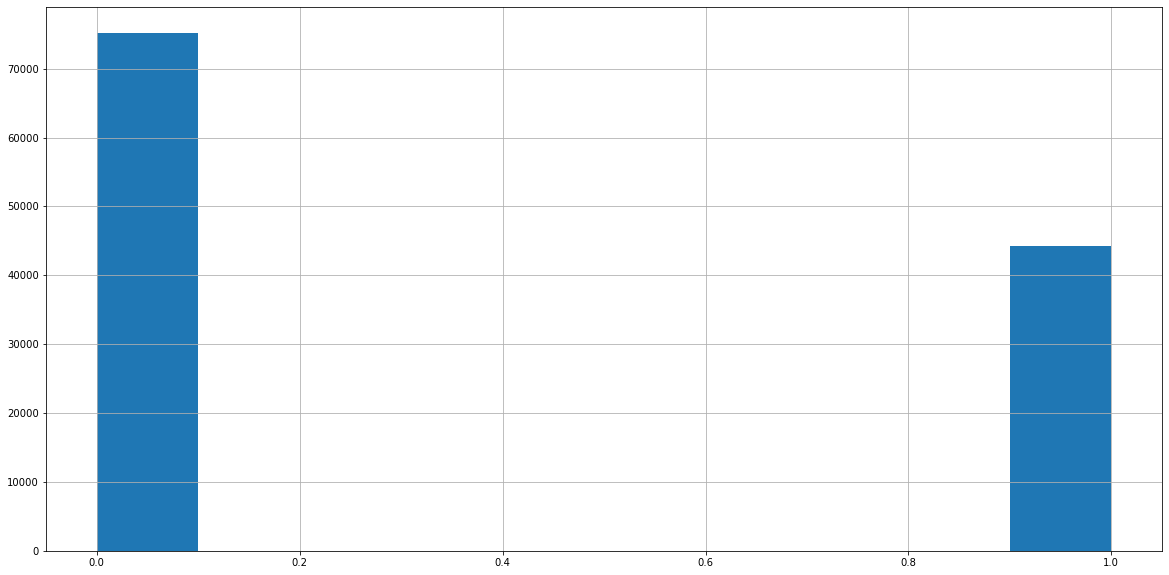

In [7]:
df.cancellation.hist();

#### NOTA
    Podemos observar que não há um grande desbalanceamento entre as classes de cancelamento e não-cancelamento, o que pode facilitar o treinamento do modelo, sem necessitar balançear as classes

#### VERIFICANDO O NÚMERO DE CANCELAMENTOS POR TIPO DE HOTEIS

In [8]:
df_cancelamentos = df[["type", "cancellation"]].groupby(["type", "cancellation"]).size().reset_index().rename(columns={0: "quantidade"})
df_cancelamentos["cancellation"] = df_cancelamentos["cancellation"].apply(lambda x: "não" if x == 0  else "sim" )
df_cancelamentos["totais"] = df_cancelamentos.groupby("type")["quantidade"].transform("sum")
df_cancelamentos["perc_iscancelamento"] = np.round((df_cancelamentos["quantidade"] / df_cancelamentos["totais"]) * 100, 2)

In [9]:
df_cancelamentos

type cancellation  quantidade  totais  perc_iscancelamento
0  Fancy Hotel          não       28938   40060                72.24
1  Fancy Hotel          sim       11122   40060                27.76
2        Hotel          não       46228   79330                58.27
3        Hotel          sim       33102   79330                41.73

In [10]:
fig = px.bar(df_cancelamentos, x="type", y="perc_iscancelamento", color="cancellation", title="Percentual de cancelamentos e não cancelamentos por tipos de hotéis")
fig.show()

In [11]:
fig = px.bar(df_cancelamentos, x="type", y="quantidade", color="cancellation", title="Número de cancelamentos por tipos de hotéis")
fig.show()

#### NOTA 
    Percebe-se que os hoteis do tipo "chique", tem um nível inferior de cancelamento em relação ao outro tipo de hotel.

#### VERIFICANDO OS MESES QUE MAIS HÁ CANCELAMENTOS

In [12]:
def convert_month_name_to_number(x):
    
    de_para_nome_mes = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7, 
        'August': 8, 
        'September':9, 
        'October':10, 
        'November': 11, 
        'December': 12,
    }
    
    return de_para_nome_mes.get(x)

In [13]:
df["month_number_arrival_date"] = df.month_arrival_date.apply(convert_month_name_to_number)

In [14]:
df_cancelamentos = df[["type", "cancellation", "month_arrival_date", "month_number_arrival_date"]].groupby(["type", "cancellation", "month_arrival_date", "month_number_arrival_date"]).size().reset_index().rename(columns={0: "quantidade"})
df_cancelamentos["cancellation"] = df_cancelamentos["cancellation"].apply(lambda x: "não" if x == 0  else "sim" )
df_cancelamentos = df_cancelamentos[df_cancelamentos["cancellation"] == "sim"]
df_cancelamentos["totais"] = df_cancelamentos.groupby(["month_number_arrival_date"])["quantidade"].transform("sum")
df_cancelamentos["perc_cancelamento"] = np.round((df_cancelamentos["quantidade"] / df_cancelamentos["totais"]) * 100, 2)

In [15]:
df_cancelamentos

type cancellation month_arrival_date  month_number_arrival_date  \
12  Fancy Hotel          sim              April                          4   
13  Fancy Hotel          sim             August                          8   
14  Fancy Hotel          sim           December                         12   
15  Fancy Hotel          sim           February                          2   
16  Fancy Hotel          sim            January                          1   
17  Fancy Hotel          sim               July                          7   
18  Fancy Hotel          sim               June                          6   
19  Fancy Hotel          sim              March                          3   
20  Fancy Hotel          sim                May                          5   
21  Fancy Hotel          sim           November                         11   
22  Fancy Hotel          sim            October                         10   
23  Fancy Hotel          sim          September                          9   
36        Hotel          sim              April                          4   
37        Hotel          sim             August                          8   
38        Hotel          sim           December                         12   
39        Hotel          sim           February                          2   
40        Hotel          sim            January                          1   
41        Hotel          sim               July                          7   
42        Hotel          sim               June                          6   
43        Hotel          sim              March                          3   
44        Hotel          sim                May                          5   
45        Hotel          sim           November                         11   
46        Hotel          sim            October                         10   
47        Hotel          sim          September                          9   

    quantidade  totais  perc_cancelamento  
12        1059    4524              23.41  
13        1637    5239              31.25  
14         631    2371              26.61  
15         795    2696              29.49  
16         325    1807              17.99  
17        1436    4742              30.28  
18        1007    4535              22.21  
19         763    3149              24.23  
20        1024    4677              21.89  
21         461    2122              21.72  
22         978    4246              23.03  
23        1006    4116              24.44  
36        3465    4524              76.59  
37        3602    5239              68.75  
38        1740    2371              73.39  
39        1901    2696              70.51  
40        1482    1807              82.01  
41        3306    4742              69.72  
42        3528    4535              77.79  
43        2386    3149              75.77  
44        3653    4677              78.11  
45        1661    2122              78.28  
46        3268    4246              76.97  
47        3110    4116              75.56

In [16]:
cond_fancy_hotel = ((df_cancelamentos["type"] == "Fancy Hotel"))

cond_hotel = ((df_cancelamentos["type"] == "Hotel"))

df_cancelamentos_fancy_hotel = df_cancelamentos[cond_fancy_hotel].sort_values("month_number_arrival_date")
df_cancelamentos_hotel = df_cancelamentos[cond_hotel].sort_values("month_number_arrival_date")

In [17]:
fig = px.line(pd.concat([df_cancelamentos_fancy_hotel, df_cancelamentos_hotel]), x="month_arrival_date", y="perc_cancelamento", color='type')
fig.show()

### MODELO 

<b>OBS:</b> Nesse primeiro momento, irei utilizar como treinamento os anos de 2015 e 2016, e o ano de 2017 como teste

#### VERIFICANDO SE HÁ NULOS NO DATASET

In [18]:
df.isnull().sum()

type                                    0
cancellation                            0
days_between_booking_arrival            0
year_arrival_date                       0
month_arrival_date                      0
week_number_arrival_date                0
day_of_month_arrival_date               0
num_weekend_nights                      0
num_workweek_nights                     0
num_adults                              0
num_children                            4
num_babies                              0
breakfast                               0
country                               488
market_segment                          0
distribution_channel                    0
repeated_guest                          0
num_previous_cancellations              0
num_previous_stays                      0
reserved_room                           0
changes_between_booking_arrival         0
deposit_policy                          0
id_travel_agency_booking            16340
id_person_booking                 

#### DROP COLUMNS ID's

In [19]:
columns_ids = ["id_travel_agency_booking", "id_person_booking", "country"]
df.drop(columns_ids, axis=1, inplace=True)

### PREPROCESSAMENTO 

#### IMPUTANDO VALORES EM VARIÁVEIS CUJO POSSUI NULOS
#### NOTA 
    1. A principio, vimos na informação do dataframe que, apenas a coluna num_children possui valores NaNs.
    2. Como são apenas quatro instâncias, iremos subistituir pela média

#### VERIFICANDO A DISTRIBUIÇÃO DE PROBABILIDADES DA VARIÁVEL NUM_CHILDREN

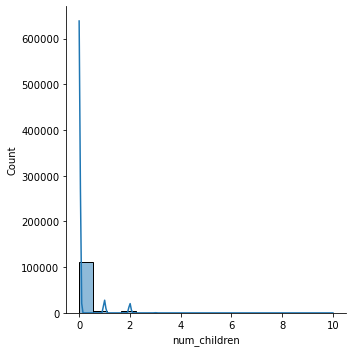

In [20]:
sns.displot(df["num_children"], kde=True);

#### VERIFICANDO SE HÁ OUTILER NA VARIÁVEL

In [21]:
px.box(data_frame = df ,x = 'num_children')

#### NOTA 

    Podemos observar que sim, há outlier na variável, visto que a maior concentração de dados está em 0, abaixo irei postar o resumo da variável

In [22]:
df["num_children"].describe()

count    119386.000000
mean          0.103890
std           0.398561
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: num_children, dtype: float64

#### NOTA 
    A média da variável é 0.10 e o desvio-padrão é 0.39, essa variável não tem muita variação, ainda assim, irei substituir os NaNs pela média e em seguida, farei um feature selection para ver o score dessa feature

In [23]:
imp_mean_children = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean_children.fit(df["num_children"].values.reshape(-1, 1))
df["num_children"] = imp_mean_children.transform(df["num_children"].values.reshape(-1, 1))

#### REALIZANDO TRANSFORMAÇÕES DE VARIÁVEIS DICOTÔMICAS E POLICOTÔMICAS PARA DUMMIES

In [24]:
one_hot_type = OneHotEncoder()
one_hot_type.fit(df["type"].values.reshape(-1, 1))


one_hot_deposit_policy = OneHotEncoder()
one_hot_deposit_policy.fit(df["deposit_policy"].values.reshape(-1, 1))


label_encoder_reserved_room = LabelEncoder()
label_encoder_reserved_room.fit(df["reserved_room"].values.reshape(-1, 1))



one_hot_type_binary = one_hot_type.transform(df["type"].values.reshape(-1, 1)).toarray()

df[one_hot_type.categories_[0]] = one_hot_type_binary.astype("int")


one_hot_deposit_policty_binary = one_hot_deposit_policy.transform(df["deposit_policy"].values.reshape(-1, 1)).toarray()

df[one_hot_deposit_policy.categories_[0]] = one_hot_deposit_policty_binary.astype("int")


df["reserved_room"] = label_encoder_reserved_room.transform(df["reserved_room"].values.reshape(-1, 1)).astype(int)



drop_columns = ["deposit_policy", "type"]

df.drop(drop_columns, axis=1, inplace=True)

In [25]:
df.columns

Index(['cancellation', 'days_between_booking_arrival', 'year_arrival_date',
       'month_arrival_date', 'week_number_arrival_date',
       'day_of_month_arrival_date', 'num_weekend_nights',
       'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
       'breakfast', 'market_segment', 'distribution_channel', 'repeated_guest',
       'num_previous_cancellations', 'num_previous_stays', 'reserved_room',
       'changes_between_booking_arrival', 'customer_type', 'avg_price',
       'required_car_parking_spaces', 'total_of_special_requests',
       'month_number_arrival_date', 'Fancy Hotel', 'Hotel', 'No Deposit',
       'Non Refund', 'Refundable'],
      dtype='object')

In [26]:
features_select = ['Fancy Hotel', 'Hotel',
                   "days_between_booking_arrival", 
                   "day_of_month_arrival_date", 
                   "num_adults", 
                   "num_children",
                   "breakfast",
                   "market_segment",
                   "distribution_channel",
                   "num_previous_cancellations",
                   "num_previous_stays",
                   "reserved_room",
                   "customer_type",
                   "avg_price",
                   "required_car_parking_spaces",
                   'No Deposit',
                   'Non Refund', 
                   'Refundable',
                   "cancellation"]

### SEPARANDO OS DADOS DE TREINO E TESTE (SEPARAÇÃO TEMPORAL)

Essa primeira sessão, será utilizando os dados de treino dos anos de 2015, 2016, para prever 2017.

In [27]:
year_for_train = [2015, 2016]
df_train = df[df["year_arrival_date"].isin(year_for_train)][features_select]
df_test = df[~df["year_arrival_date"].isin(year_for_train)][features_select]

print("Tamanho dataset train = ", df_train.shape, "Tamanho dataset test = ",df_test.shape)

Tamanho dataset train =  (78703, 19) Tamanho dataset test =  (40687, 19)


In [28]:
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1:].values.flatten()


X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1:].values.flatten()

### CRIANDO OS MODELOS 

#### TREINANDO O MODELO

<b>OBS:</b> Nesse exemplo, iremos utilizar <b>RandomForestClassfier</b>

In [29]:
clf_rf = RandomForestClassifier(n_estimators=100)

In [30]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [31]:
y_pred = clf_rf.predict(X_test)

In [32]:
print("Acurácia do modelo = ",accuracy_score(y_test, y_pred))

Acurácia do modelo =  0.7257354929092831


In [33]:
y_pred = clf_rf.predict(X_test)

In [34]:
def plot_confusion_matrix(cf_matrix, labels):
    
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

    ax.set_title('Matriz de confusão');
    ax.set_xlabel('Previsões Cancelamentos')
    ax.set_ylabel('Observações Originais');

    
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    
    plt.show();

In [35]:
cf_matrix = confusion_matrix(y_test, y_pred)
labels = ["não", "sim"]

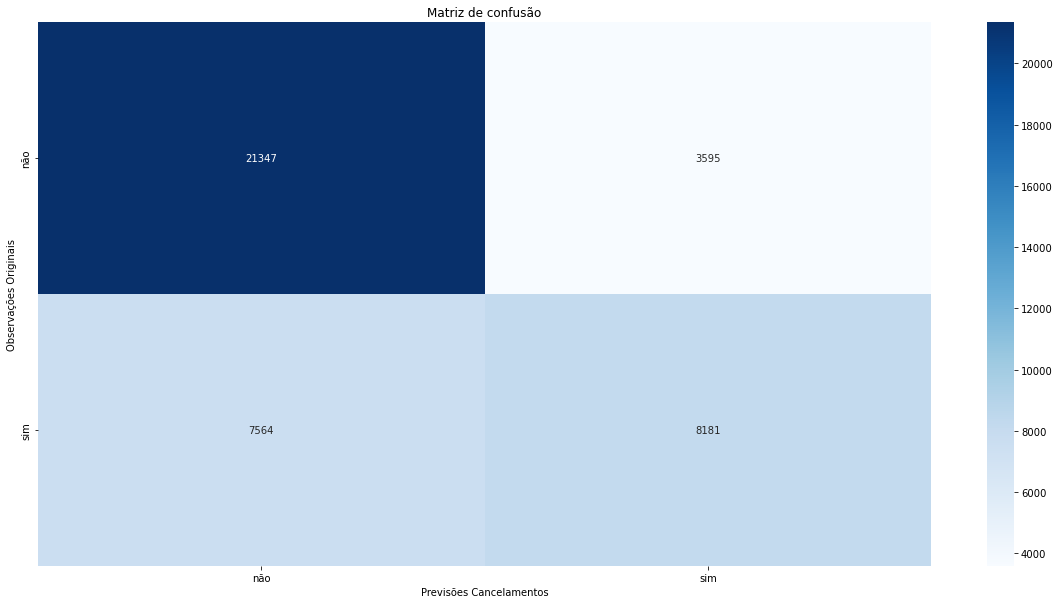

In [36]:
plot_confusion_matrix(cf_matrix, labels);

In [37]:
print(classification_report(y_test, y_pred,  target_names=labels))

              precision    recall  f1-score   support

         não       0.74      0.86      0.79     24942
         sim       0.69      0.52      0.59     15745

    accuracy                           0.73     40687
   macro avg       0.72      0.69      0.69     40687
weighted avg       0.72      0.73      0.72     40687



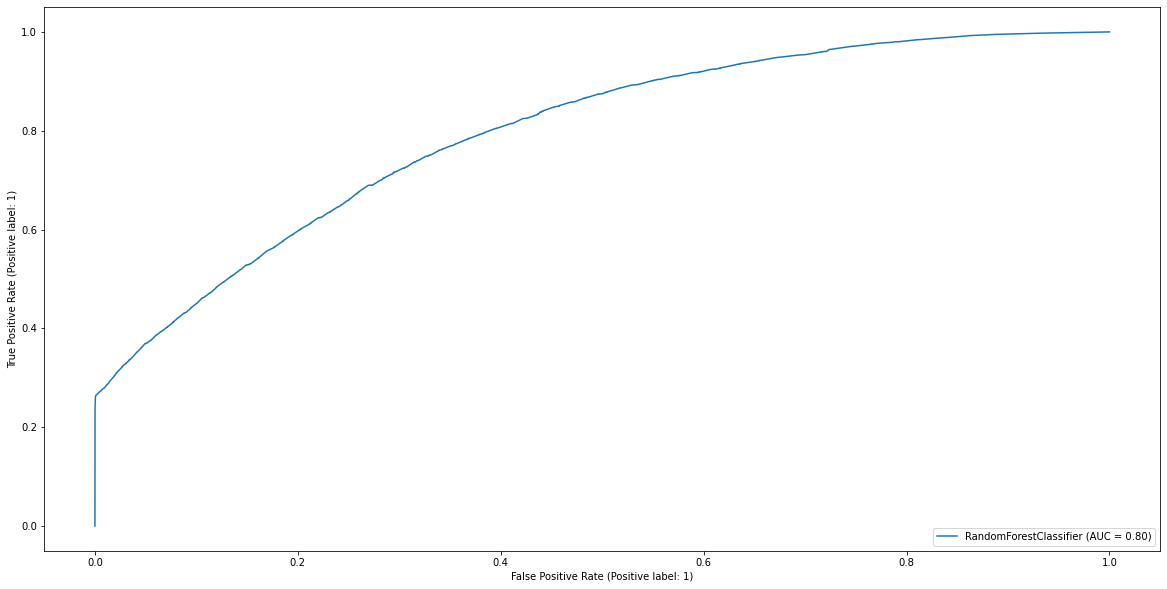

In [38]:
plot_roc_curve(clf_rf, X_test, y_test);

#### TREINANDO O MODELO

<b>OBS:</b> Nesse segundo exemplo, iremos utilizar <b>LogisticRegression</b>

In [39]:
clf_logreg = LogisticRegression(max_iter=1000)

In [40]:
clf_logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [41]:
y_pred = clf_logreg.predict(X_test)

In [42]:
print("Acurácia do modelo = ",accuracy_score(y_test, y_pred))

Acurácia do modelo =  0.7260304274092462


In [43]:
cf_matrix = confusion_matrix(y_test, y_pred)
labels = ["não", "sim"]

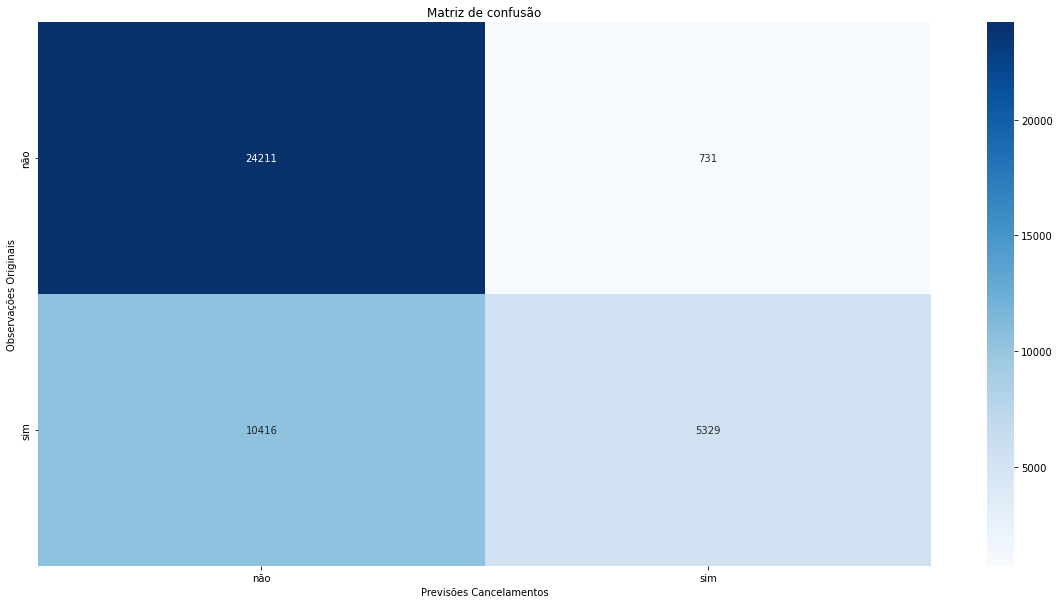

In [44]:
plot_confusion_matrix(cf_matrix, labels);

In [45]:
print(classification_report(y_test, y_pred,  target_names=labels))

              precision    recall  f1-score   support

         não       0.70      0.97      0.81     24942
         sim       0.88      0.34      0.49     15745

    accuracy                           0.73     40687
   macro avg       0.79      0.65      0.65     40687
weighted avg       0.77      0.73      0.69     40687



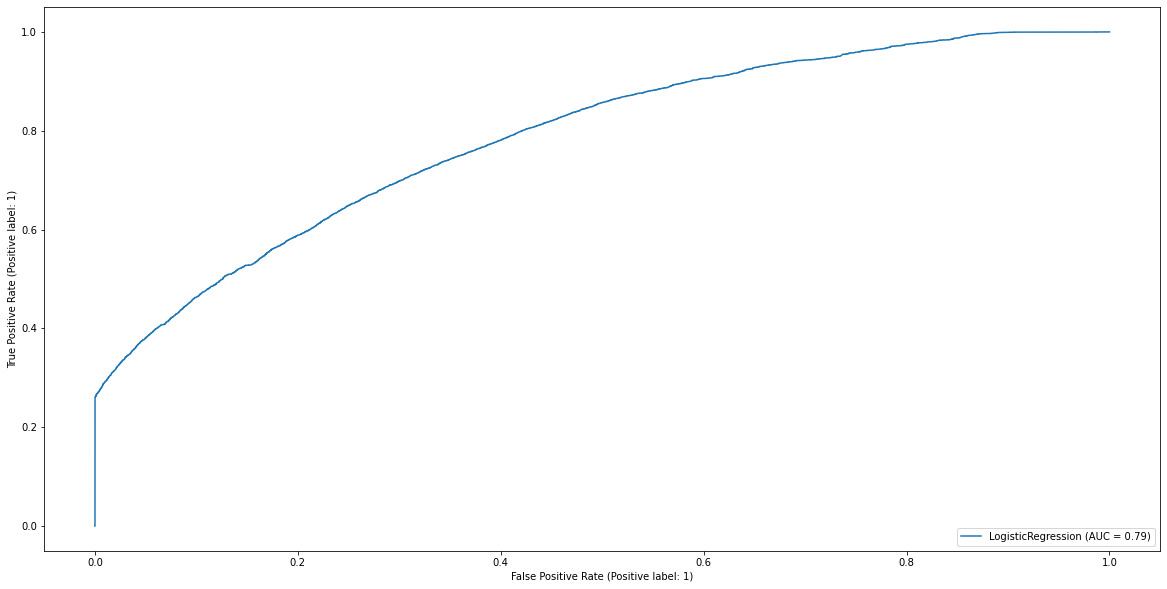

In [46]:
plot_roc_curve(clf_logreg, X_test, y_test);

#### NOTA 

    Comparando os dois modelos, podemos observar que o modelo de Florestas Aleatórias ou RandomForest, deu resultados bem satisfatórios, uma acurácia de 72.73 e um f1-score de 79% para a classe "não" que indica que não cancelou e para a classe "sim", que indica que houve cancelamento, um f1-score de 60%. Lá no inicio do código, tem um plot que indica o balanceamento da classe e vimos que a classe 0 ("não cancelamento") levemente superior a classe 1 ("sim"), para tentarmos equilibrar as classes e aumentar o f1-score, iremos utilizar o SMOTE para criar amostras sintéticas das classes e retreinar os modelos.

### SMOTE

Utilizando o <b>RandomForestClassfier</b>

In [47]:
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import RandomOverSampler

In [48]:
rus = RandomUnderSampler(random_state=0)
X_res, y_res= rus.fit_resample(X_train, y_train)

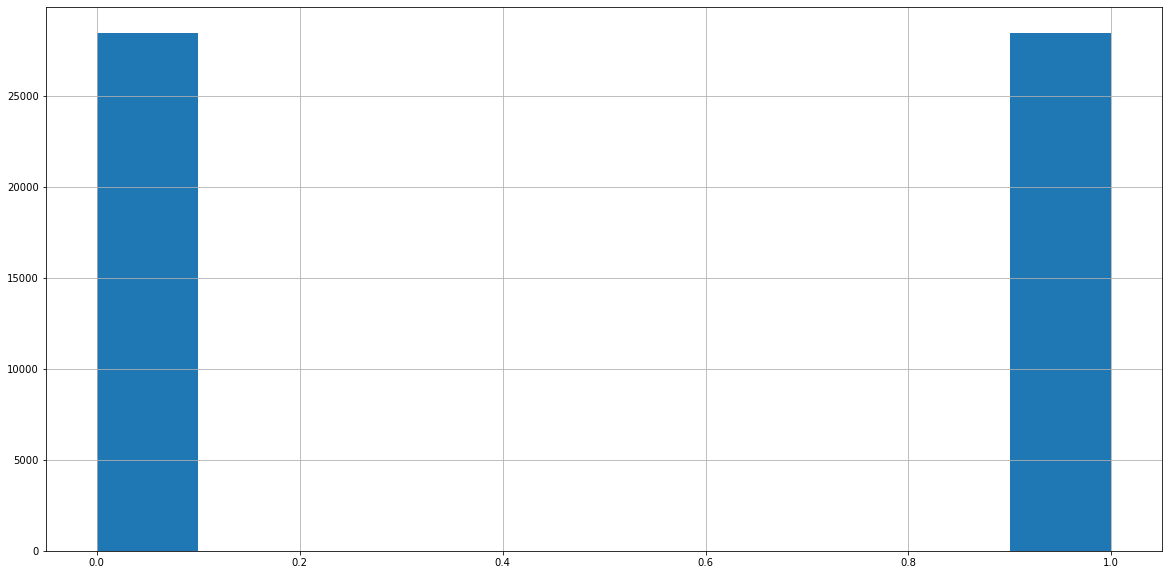

In [49]:
pd.Series(y_res).hist();

In [50]:
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_res, y_res)

RandomForestClassifier()

In [51]:
y_pred = clf_rf.predict(X_test)

In [52]:
print("Acurácia do modelo = ",accuracy_score(y_test, y_pred))

Acurácia do modelo =  0.7189274215351341


In [53]:
cf_matrix = confusion_matrix(y_test, y_pred)
labels = ["não", "sim"]

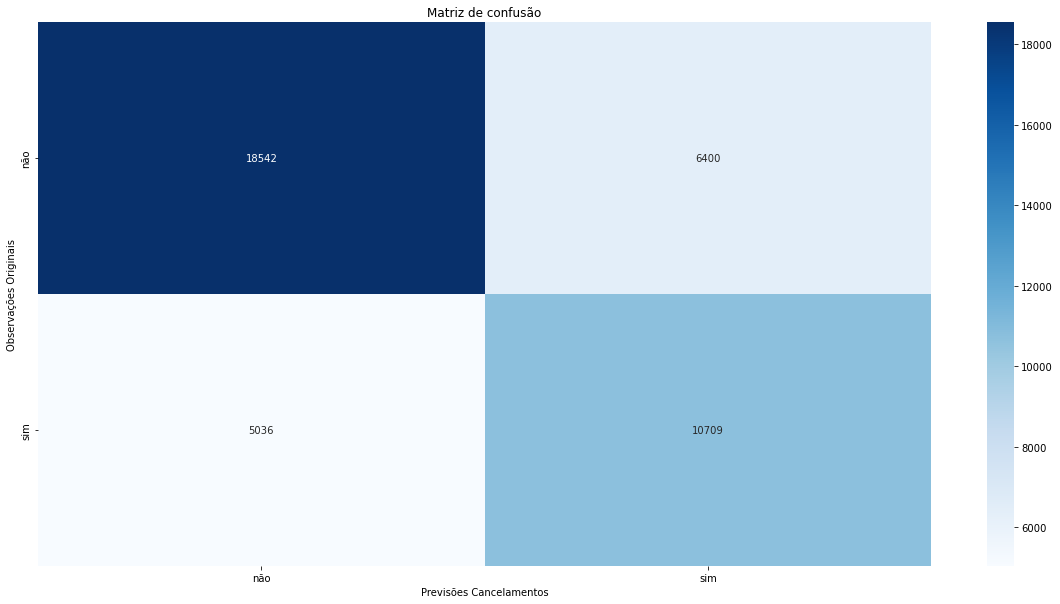

In [54]:
plot_confusion_matrix(cf_matrix, labels);

In [55]:
print(classification_report(y_test, y_pred,  target_names=labels))

              precision    recall  f1-score   support

         não       0.79      0.74      0.76     24942
         sim       0.63      0.68      0.65     15745

    accuracy                           0.72     40687
   macro avg       0.71      0.71      0.71     40687
weighted avg       0.72      0.72      0.72     40687



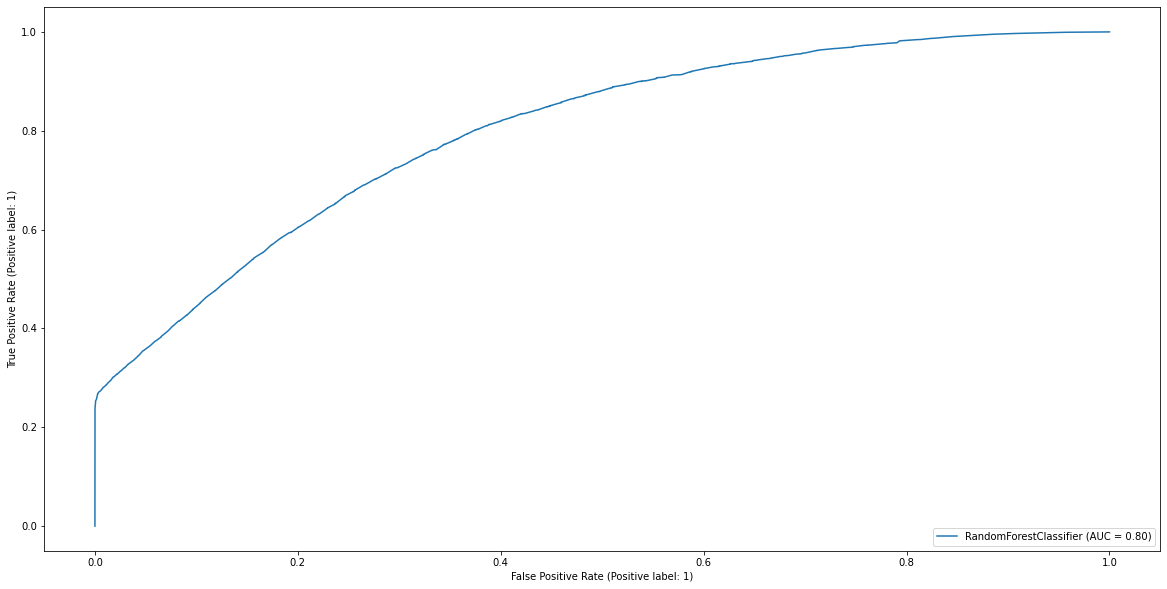

In [56]:
plot_roc_curve(clf_rf, X_test, y_test);

Utilizando o <b>LogisticRegression</b>

In [57]:
clf_logreg = LogisticRegression(max_iter=1000)
clf_logreg.fit(X_res, y_res)

LogisticRegression(max_iter=1000)

In [58]:
y_pred = clf_logreg.predict(X_test)

In [59]:
print("Acurácia do modelo = ",accuracy_score(y_test, y_pred))

Acurácia do modelo =  0.712119350160985


In [60]:
cf_matrix = confusion_matrix(y_test, y_pred)
labels = ["não", "sim"]

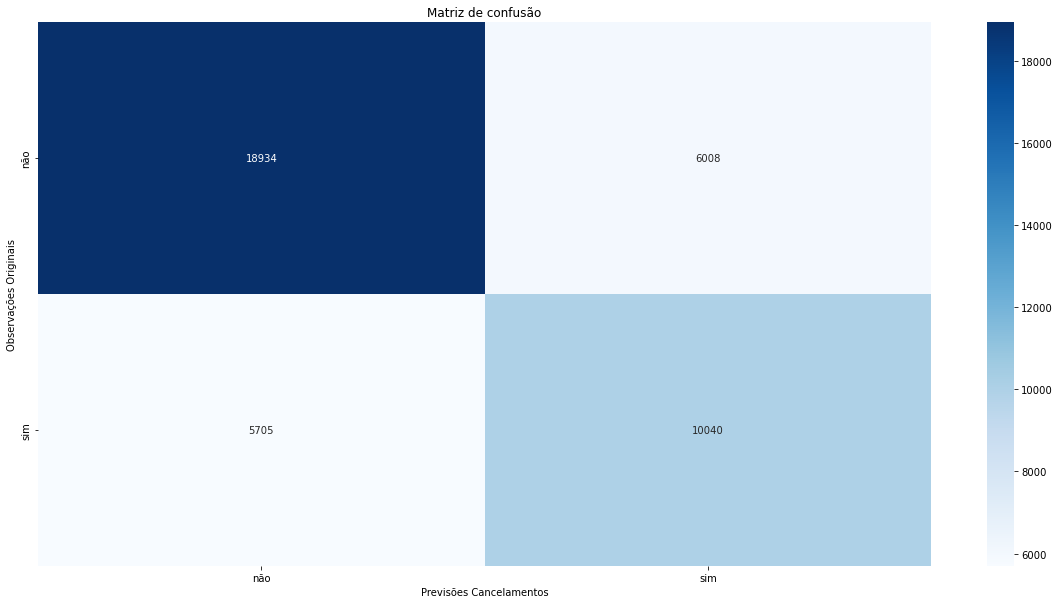

In [61]:
plot_confusion_matrix(cf_matrix, labels);

In [62]:
print(classification_report(y_test, y_pred,  target_names=labels))

              precision    recall  f1-score   support

         não       0.77      0.76      0.76     24942
         sim       0.63      0.64      0.63     15745

    accuracy                           0.71     40687
   macro avg       0.70      0.70      0.70     40687
weighted avg       0.71      0.71      0.71     40687



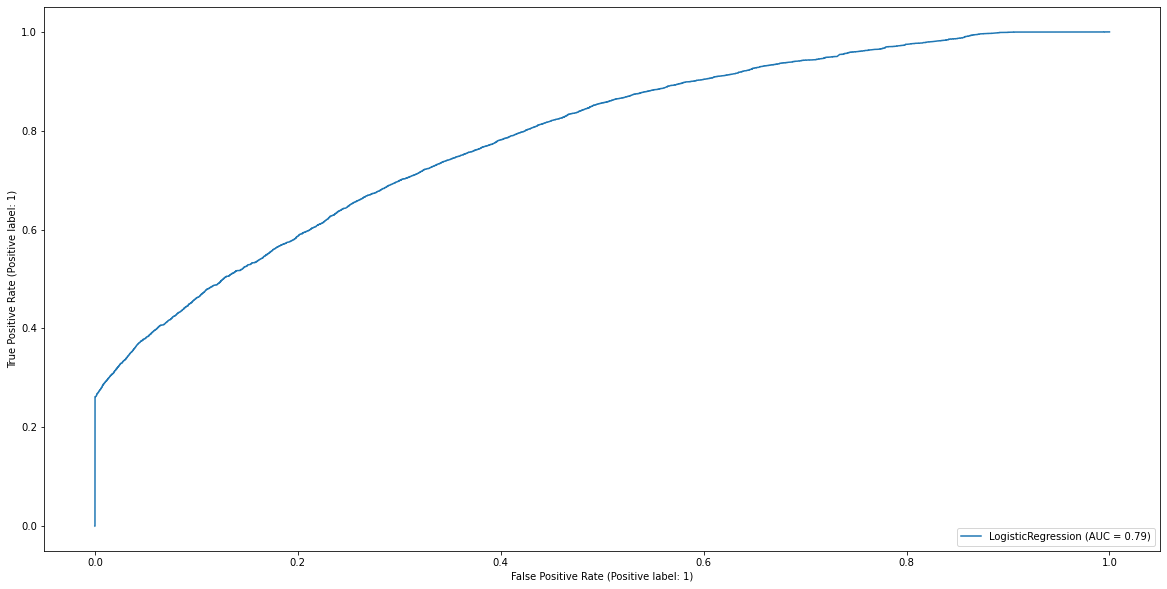

In [63]:
plot_roc_curve(clf_logreg, X_test, y_test);

#### NOTA
    No geral, os modelos com SMOTE tem uma leve melhora quando comparado com os modelos anteriores, sem o balancamento das classes. Ainda assim, o modelo de Florestas aleatórias se sai melhor em relação ao modelo de Regressão Logistica, abaixo as métricas:
    
    RandomForest 
        1. Acurácia: 0.7180
        2. f1-score: Para classe "sim" -> 0.76 , para classe "não" -> 0.65
        3. CURVA ROC: 0.79
    
    LogisticRegression
        1. Acurácia: 0.7121
        2. f1-score: Para classe "sim" -> 0.76 , para classe "não" -> 0.63
        3. CURVA ROC: 0.79
    
    

### SEPARANDO OS DADOS DE TREINO E TESTE (TRAIN_TEST_SPLIT)

Nessa segunda sessão, será utilizando o <b>train_test_split</b>, para separar os dados de treino e teste

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X = df[features_select].iloc[:, :-1]
Y = df[features_select].iloc[:, -1:]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, Y.values.flatten(), test_size=0.2, stratify=Y)

In [67]:
from imblearn.under_sampling import RandomUnderSampler

In [68]:
rus = RandomUnderSampler(random_state=0)
X_res, y_res= rus.fit_resample(X_train, y_train)

Utilizando o <b>RandomForestClassfier</b>

In [69]:
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_res, y_res)

RandomForestClassifier()

In [70]:
y_pred = clf_rf.predict(X_test)

In [71]:
print("Acurácia do modelo = ",accuracy_score(y_test, y_pred))

Acurácia do modelo =  0.809154870592177


In [72]:
cf_matrix = confusion_matrix(y_test, y_pred)
labels = ["não", "sim"]

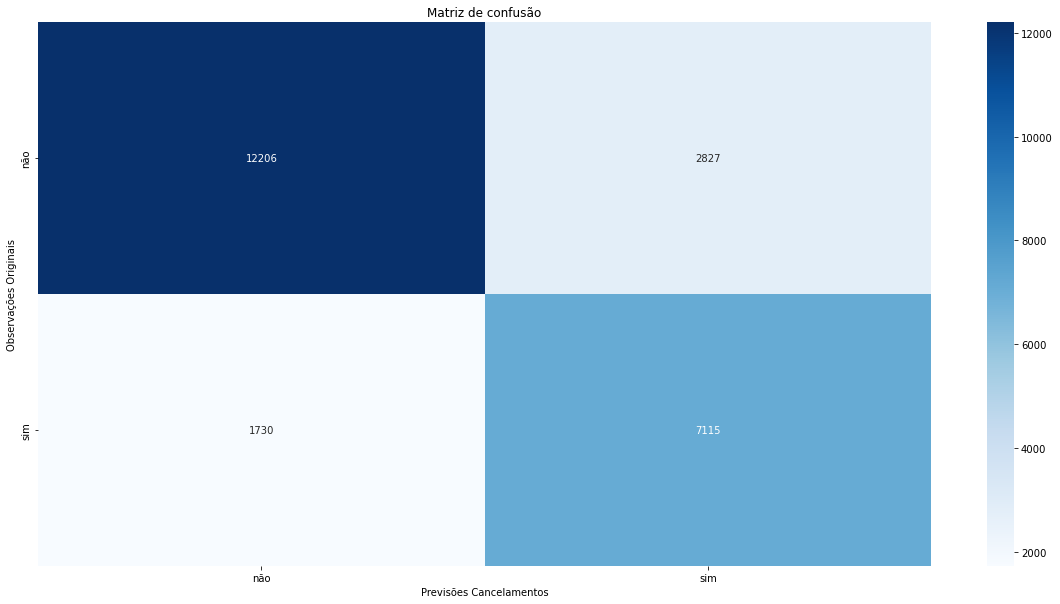

In [73]:
plot_confusion_matrix(cf_matrix, labels);

In [74]:
print(classification_report(y_test, y_pred,  target_names=labels))

              precision    recall  f1-score   support

         não       0.88      0.81      0.84     15033
         sim       0.72      0.80      0.76      8845

    accuracy                           0.81     23878
   macro avg       0.80      0.81      0.80     23878
weighted avg       0.82      0.81      0.81     23878



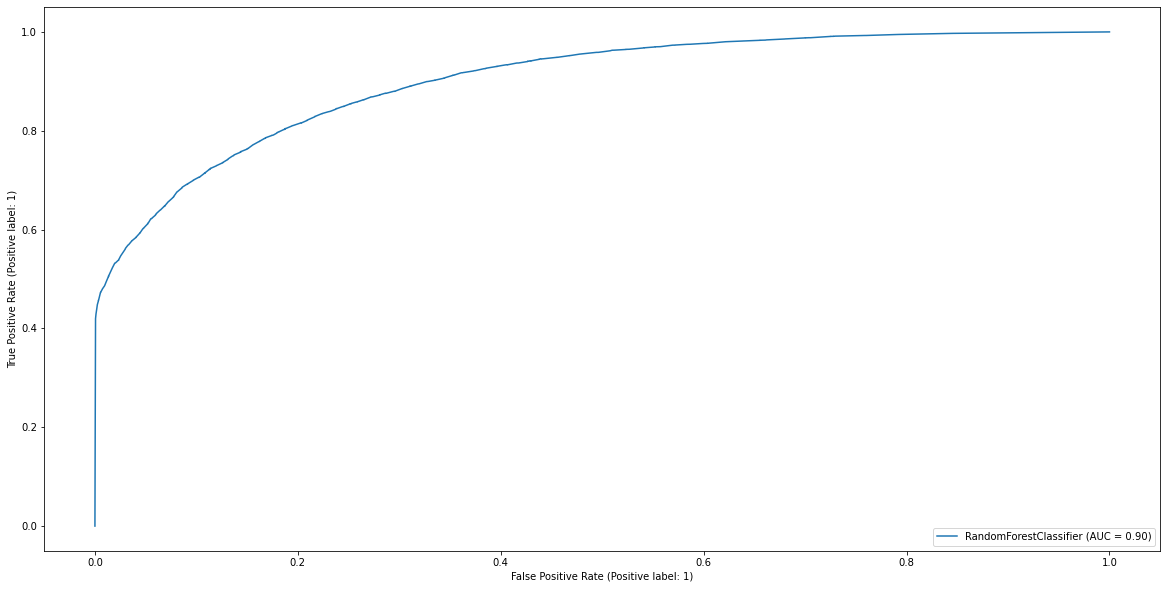

In [75]:
plot_roc_curve(clf_rf, X_test, y_test);

Utilizando o <b>LogisticRegression</b>

In [76]:
clf_logreg = LogisticRegression(max_iter=1000)

clf_logreg.fit(X_res, y_res)

LogisticRegression(max_iter=1000)

In [77]:
y_pred = clf_logreg.predict(X_test)

In [78]:
print("Acurácia do modelo = ",accuracy_score(y_test, y_pred))

Acurácia do modelo =  0.7563447524918335


In [79]:
cf_matrix = confusion_matrix(y_test, y_pred)
labels = ["não", "sim"]

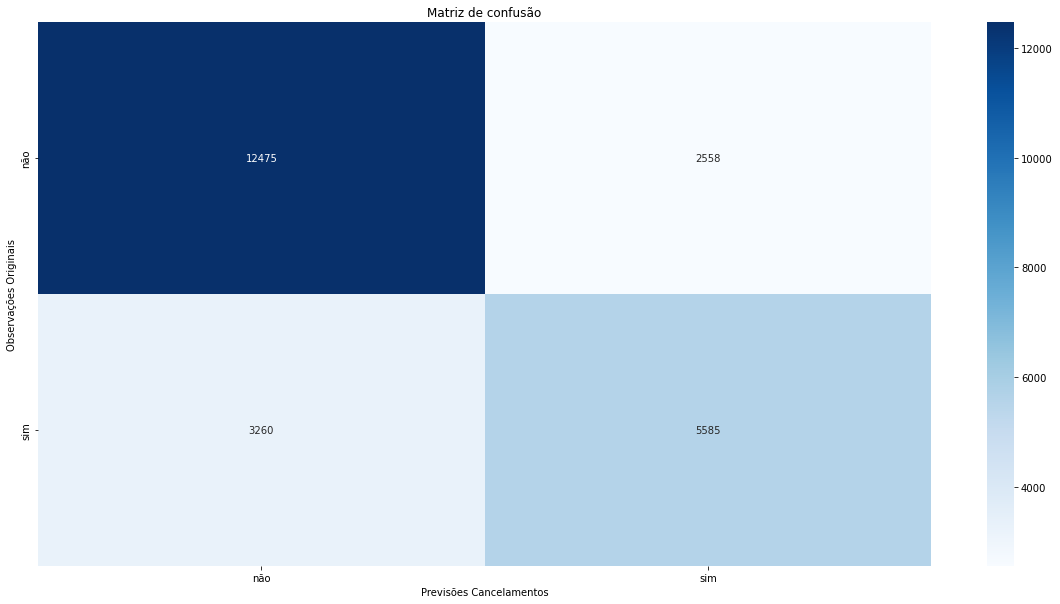

In [80]:
plot_confusion_matrix(cf_matrix, labels);

In [81]:
print(classification_report(y_test, y_pred,  target_names=labels))

              precision    recall  f1-score   support

         não       0.79      0.83      0.81     15033
         sim       0.69      0.63      0.66      8845

    accuracy                           0.76     23878
   macro avg       0.74      0.73      0.73     23878
weighted avg       0.75      0.76      0.75     23878



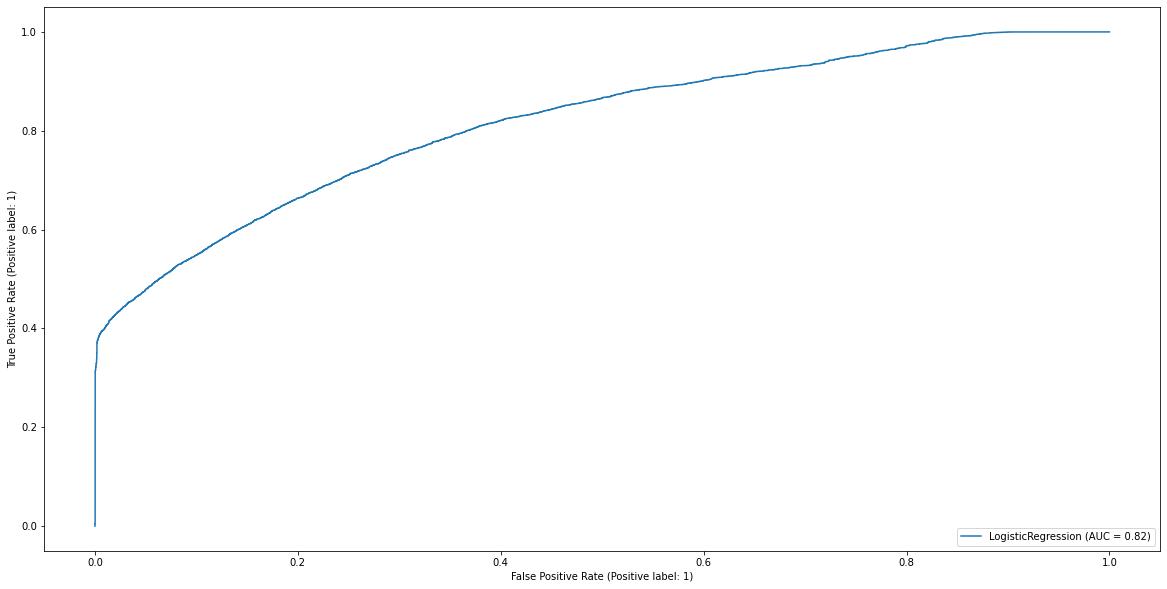

In [82]:
plot_roc_curve(clf_logreg, X_test, y_test);

#### NOTA 
    Utilizando a metodologia de train_test_split, os modelos tem uma melhora considerável em relação a metodologia anterior, onde se utiliza os anos de 2015 e 2016 para prever 2017.

### SEPARANDO OS DADOS DE TREINO E TESTE (VALIDAÇÃO CRUZADA)

Nessa segunda sessão, será utilizando o <b>cross_val_score</b>, validação cruzada.

<b>OBS:</b>Um ponto importante é, como estamos utilizando validação cruzada, é importante que se utilize todo o dataset para medirmos o desempenho geral do modelo.

Utilizando <b>RandomForestClassifier</b>

In [83]:
X_, y_ = df[features_select].iloc[:, :-1].values, df.iloc[:, -1:].values.flatten()

In [84]:
clf_rf = RandomForestClassifier(max_depth=None)

cv = StratifiedKFold(n_splits=10, shuffle=True) 

stats_scores = cross_val_score(clf_rf, X_, y_ , cv=cv)

In [85]:
print("Desempenho geral do modelo... Média dos scores=", np.mean(stats_scores), "Desvio-padrão dos scores=", np.std(stats_scores))

Desempenho geral do modelo... Média dos scores= 1.0 Desvio-padrão dos scores= 0.0


Utilizando <b>LogisticRegression</b>

In [86]:
clf_logreg = LogisticRegression(max_iter=1000)

cv = StratifiedKFold(n_splits=10, shuffle=True)  

stats_scores = cross_val_score(clf_logreg, X_, y_, cv=cv)

In [87]:
print("Desempenho geral do modelo... Média dos scores=", np.mean(stats_scores), "Desvio-padrão dos scores=", np.std(stats_scores))

Desempenho geral do modelo... Média dos scores= 1.0 Desvio-padrão dos scores= 0.0


#### NOTA 
    Na sessão acima discutida, realizamos algumas metodologias de treino, foram elas:
    
    1. Separação de treino e teste de forma temporal, onde escolhemos 2015 e 2016 para treino e 2017 para teste.
    2. Separação utilizando train_test_split, onde retemos 20% dos dados para teste.
    3. Validação cruzada. 
    
    Comentando um pouco sobre as metodologias. Vimos que entre as três há sim diferenças. Na separação temporal, que foi a que deu um pior resultado, isso ocorreu pelo fato das amostras das amostras de teste de 2017, serem muito diferentes das amostras de 2015 e 2016 nos dados de treinamento, o que dificulta a generalização do modelo. Já na abordagem train_test_split, torna-se um pouco diferente, pois, embora eu separe 20% para teste de forma aleatória, uma grande amostra desses 20%, estão contidos nos dados de treinamento e portanto, o modelo consegue generalizar bem e ter um bom resultado. Na abordagem utilizando a Validação Cruzada, é o método preferido porque dá ao modelo a oportunidade de treinar em várias divisões de treino e teste. Isso dá uma melhor indicação quão bem seu modelo irá funcionar em dados invisíveis, ou dados que ele ainda nunca viu.

### REALIZANDO FEATURES IMPORTANCES

A ideia aqui é tentar rezudir a dimensionalidade, com o intuito de retirar variáveis que são insignificantes estatísticamente, de modo que não cause ruidos no modelo.

In [88]:
clf_rf = RandomForestClassifier(n_estimators=100)

clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [89]:
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)

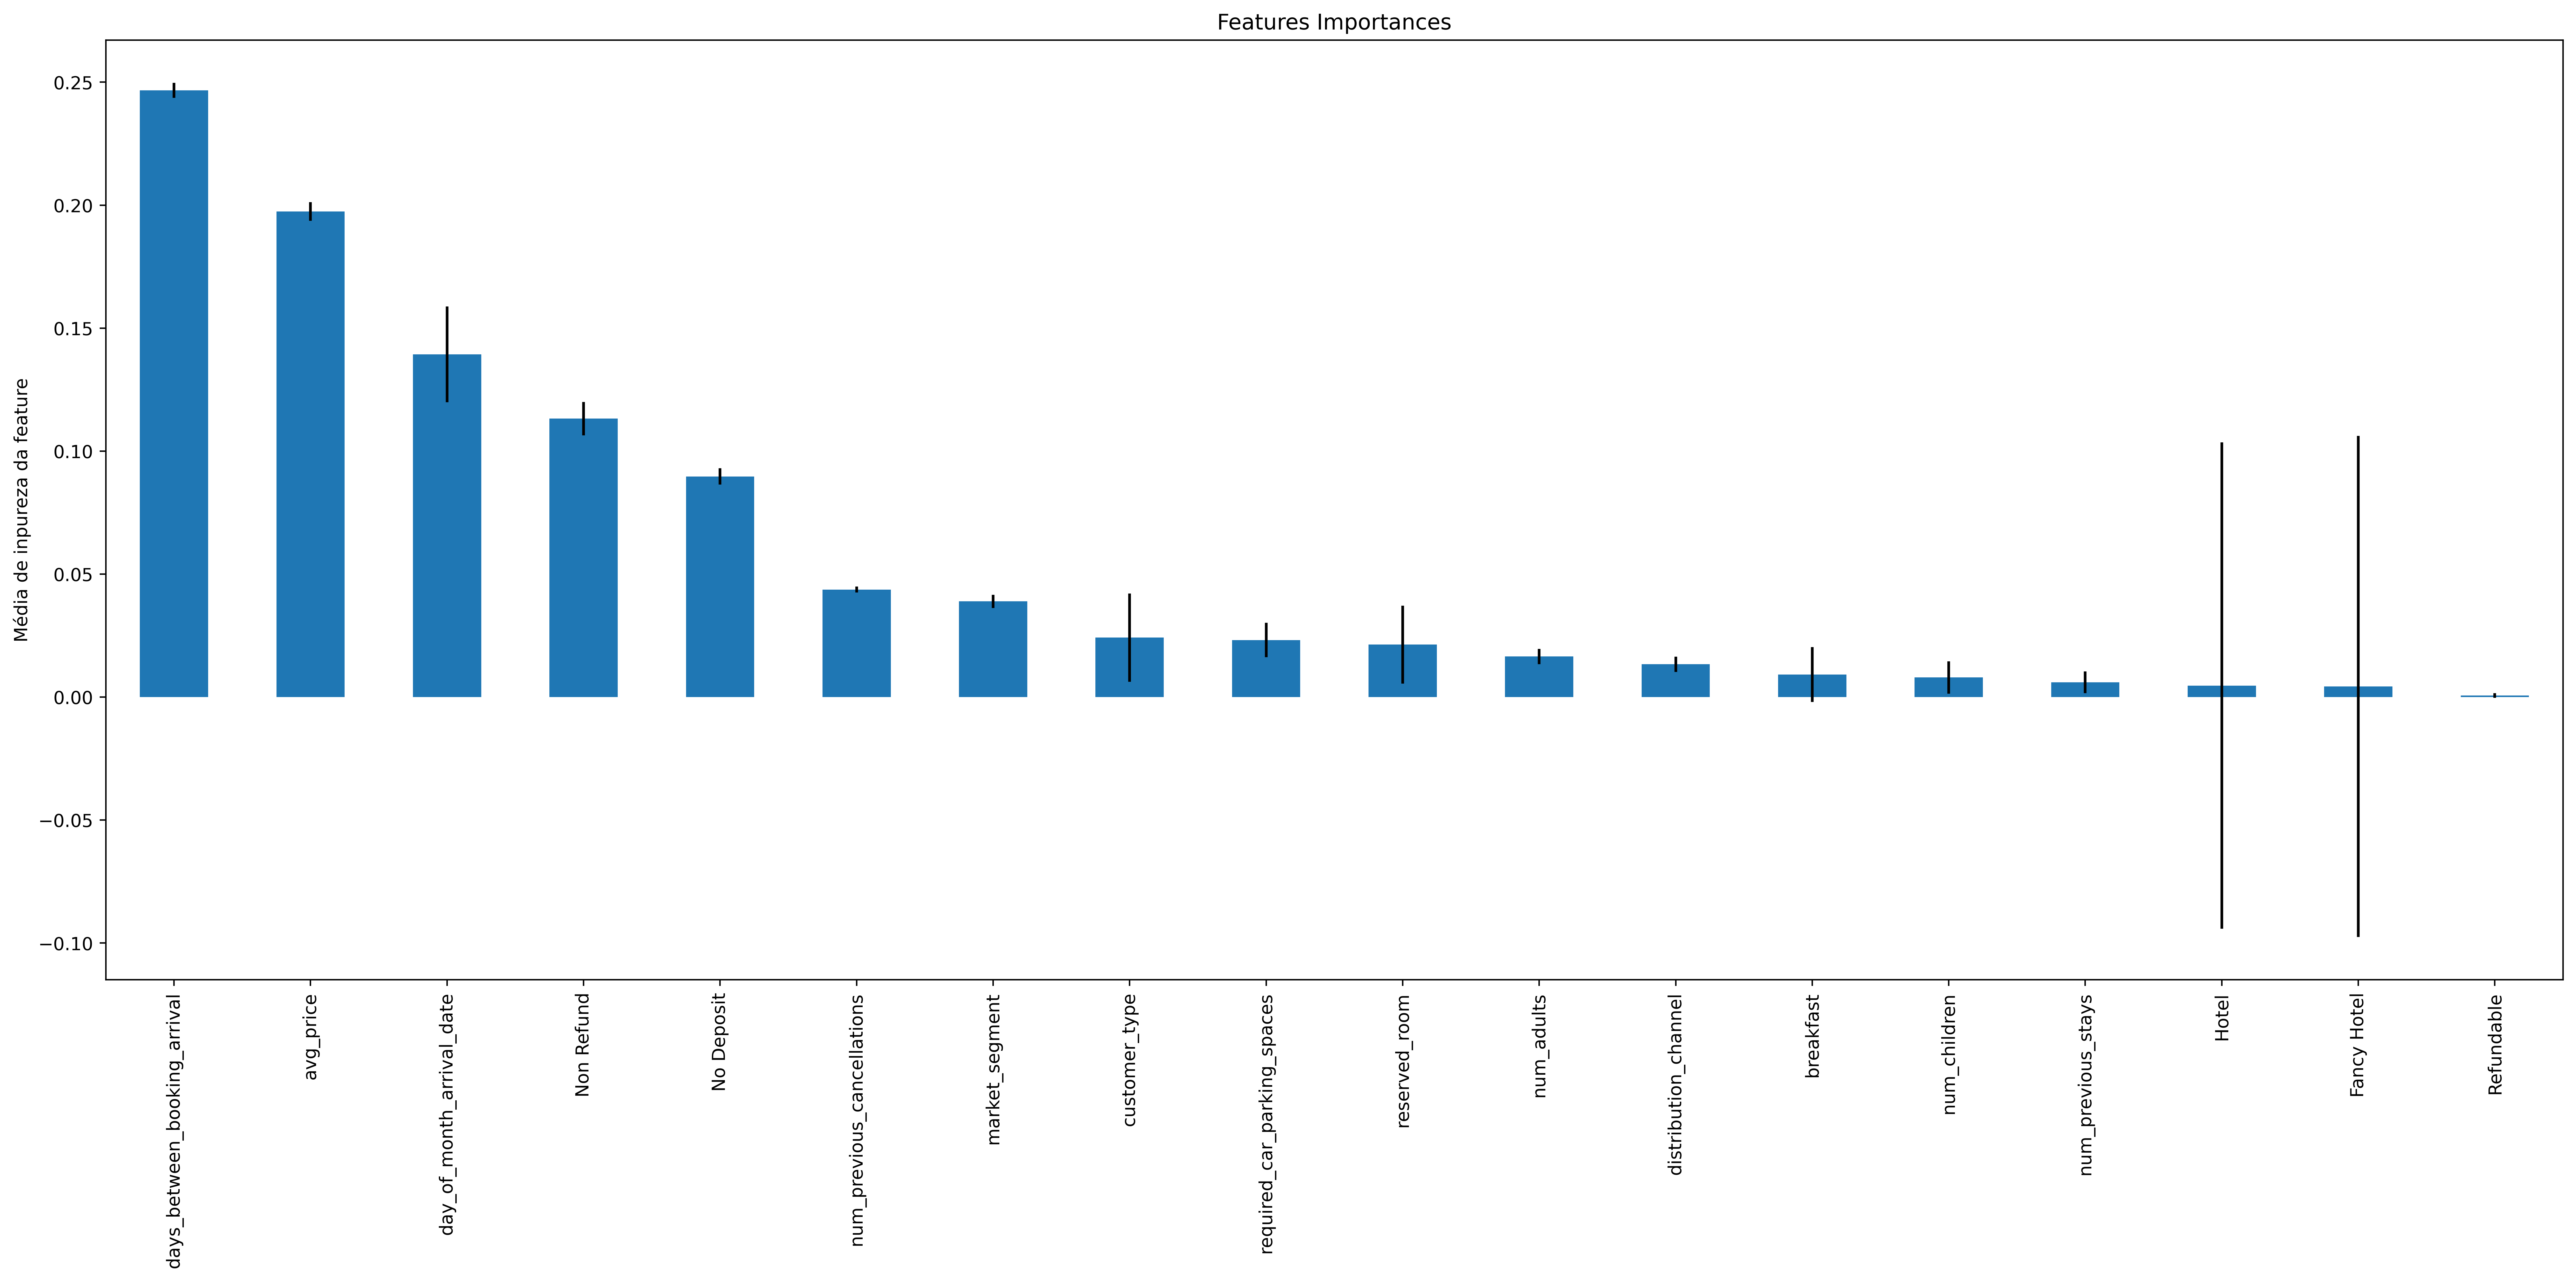

In [90]:
features_importances = pd.Series(importances, index=features_select[:-1])

fig, ax = plt.subplots(dpi=500)
features_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Features Importances")
ax.set_ylabel("Média de inpureza da feature")
fig.tight_layout()

#### SELECIONANDO FEATURES COM UMA PONTUAÇÃO MAIOR QUE 0.01

In [91]:
features_importances[features_importances > 0.01].sort_values(ascending=False)

days_between_booking_arrival    0.246680
avg_price                       0.197409
day_of_month_arrival_date       0.139329
Non Refund                      0.113191
No Deposit                      0.089697
num_previous_cancellations      0.043710
market_segment                  0.038881
customer_type                   0.024150
required_car_parking_spaces     0.023186
reserved_room                   0.021306
num_adults                      0.016469
distribution_channel            0.013317
dtype: float64

In [92]:
new_features = [i for i in features_importances[features_importances > 0.01].index]

In [93]:
new_features.append("Refundable")
new_features.append("cancellation")

In [94]:
new_features

['days_between_booking_arrival',
 'day_of_month_arrival_date',
 'num_adults',
 'market_segment',
 'distribution_channel',
 'num_previous_cancellations',
 'reserved_room',
 'customer_type',
 'avg_price',
 'required_car_parking_spaces',
 'No Deposit',
 'Non Refund',
 'Refundable',
 'cancellation']

#### NOTA
    Acima, as melhores variáveis, após a redução de dimensionalidade. Considerei as variáveis com pontuações acima de 0.01. Poderia aumentar o valor desse filtro? Sim, mas, iria reduzir bastante o número de variáveis e claro, esse é um método estátistico e que eventualmente, poderá penalizar uma variável importante para o modelo, embora essa variável, nos dados atuais, não tenha tanta significância estatística. 

### TREINANDO O MODELO O MODELO APÓS A REDUÇÃO DE DIMENSIONALIDADE

In [95]:
X = df[new_features].iloc[:, :-1]
Y = df[new_features].iloc[:, -1:]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, Y.values.flatten(), test_size=0.2, stratify=Y)

In [97]:
rus = RandomUnderSampler(random_state=0)
X_res, y_res= rus.fit_resample(X_train, y_train)

In [98]:
clf_rf = RandomForestClassifier(n_estimators=100)

clf_rf.fit(X_res, y_res)

RandomForestClassifier()

In [99]:
y_pred = clf_rf.predict(X_test)

In [100]:
print("Acurácia do modelo = ",accuracy_score(y_test, y_pred))

Acurácia do modelo =  0.7986012228829885


In [101]:
cf_matrix = confusion_matrix(y_test, y_pred)
labels = ["não", "sim"]

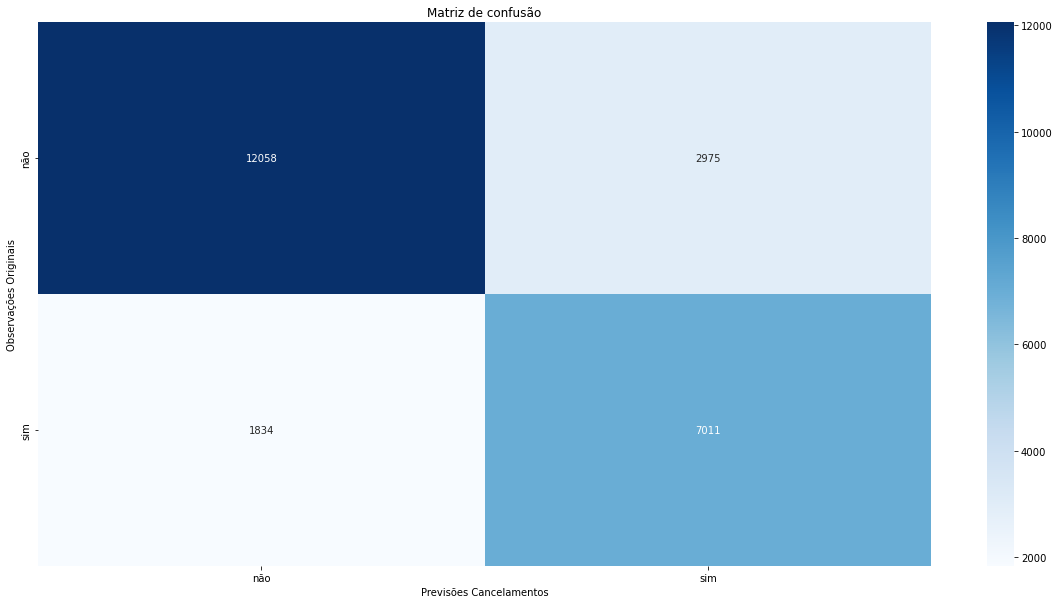

In [102]:
plot_confusion_matrix(cf_matrix, labels);

In [103]:
print(classification_report(y_test, y_pred,  target_names=labels))

              precision    recall  f1-score   support

         não       0.87      0.80      0.83     15033
         sim       0.70      0.79      0.74      8845

    accuracy                           0.80     23878
   macro avg       0.79      0.80      0.79     23878
weighted avg       0.81      0.80      0.80     23878



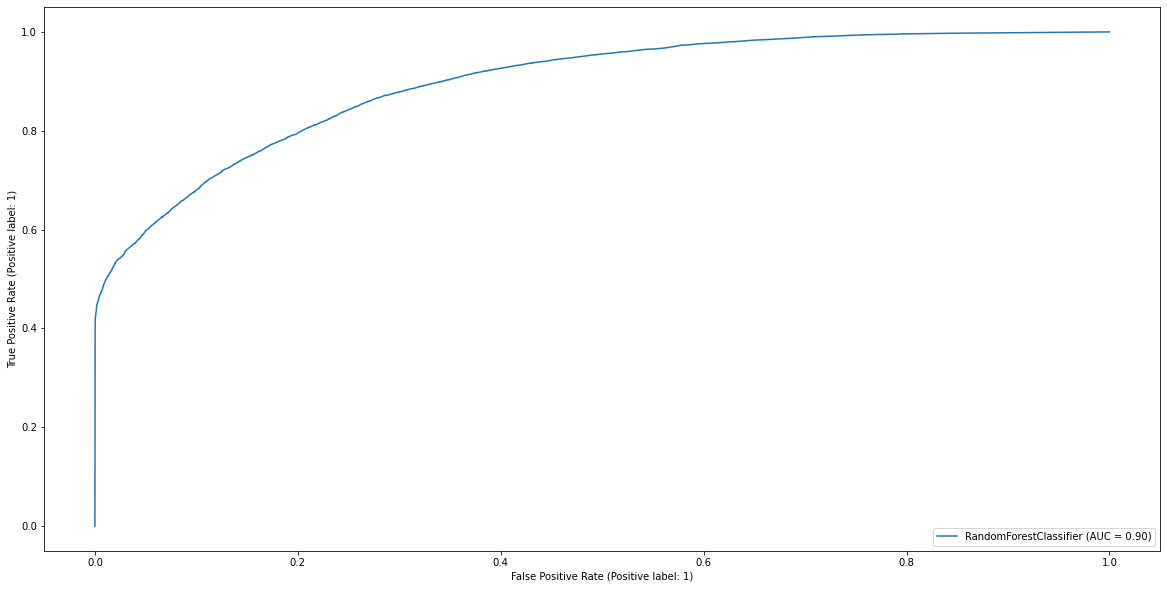

In [104]:
plot_roc_curve(clf_rf, X_test, y_test);

#### NOTA
    Após a redução de dimensionalidade, podemos ver que o modelo melhorou ainda mais um pouco no seu f1-score, passando para 0.84 na classe "não" (não-cancelamento) e 0.75 para classe "sim" (houve-cancelamento)

### PLOT FRONTEIRAS DE DECISÃO

<Figure size 1440x720 with 0 Axes>

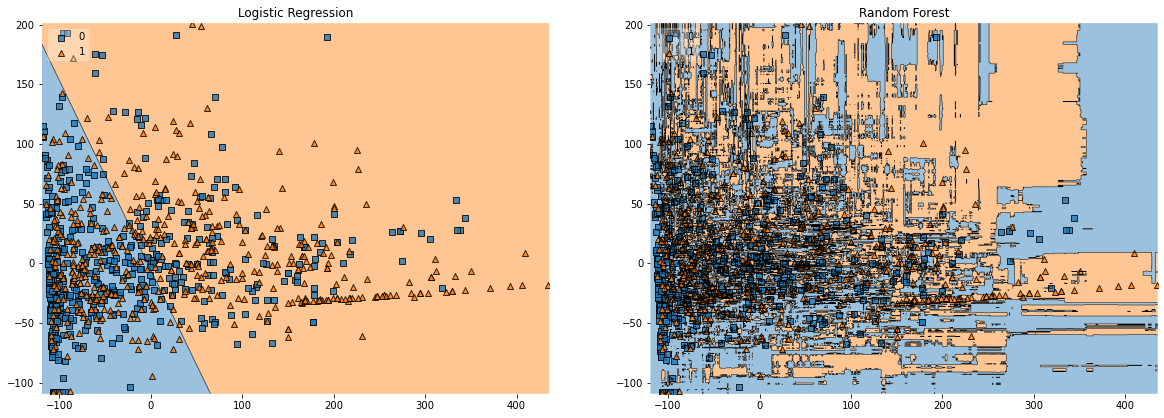

In [105]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec
import itertools


gs = gridspec.GridSpec(3, 2)
fig = plt.figure(figsize=(20,10))

sample = 20000

pca = PCA(n_components = 2)
X_res_pca = pca.fit_transform(X_res)


clf_logreg = LogisticRegression(max_iter=1000)
clf_rf = RandomForestClassifier(n_estimators=100)



lista_x = []
lista_y = []
sample = 500

for i in np.where(y_res == 1)[0][0:sample]:
    lista_x.append(X_res_pca[i])
    lista_y.append(y_res[i])

for i in np.where(y_res == 0)[0][0:sample]:
    lista_x.append(X_res_pca[i])
    lista_y.append(y_res[i])
    
new_x = np.array(lista_x)
new_y = np.array(lista_y)



gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(20,15))

labels = ['Logistic Regression', 'Random Forest',]
for clf, lab, grd in zip([clf_logreg, clf_rf],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_res_pca, y_res)
    ax = plt.subplot(gs[grd[0], grd[1]])
    
    fig = plot_decision_regions(X=new_x, y=new_y, clf=clf, legend=2)
    plt.title(lab)

plt.show();

#### NOTA 

    Através dos gráficos de fronteiras de decisão, concluimos que os dados não são dados lineares e portanto, o modelo de Florestas Aleátorias se sobressai melhor em relação ao de Regressão Logistica, visto que o modelo Regressão Logistica é um modelo Linear.

### CONCLUSÃO

Ao longo de todo o estudo, vimos que o modelo de Florestas Aletórias se saiu bem superior ao modelo Linear de Regressão Logística, isso se provou mais ainda, após verificarmos as fronteiras de decisão de ambos modelos, onde ficou claro, a natureza não linear dos dados. Pontuamos também que o modelo com as classes balanceadas utilizando o recurso do <b>SMOTE</b>, teve uma melhora bastante considerável no seu <b>f1-score</b> e também na <b>curva roc</b>. Esse modelo, pode ser ainda melhorado, podemos por exemplo, acrescentar mais variáveis que dizem respeito ao cliente, variáveis que possam levar o cliente ao cancelamento da reserva.